In [13]:
import os
import sys

ROOT_DIR = r"C:\Users\Anushika Mishra\OneDrive\datascience_project"
## Change ROOT_DIR to your working directory.
os.chdir(ROOT_DIR)
sys.path.append(ROOT_DIR)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
ID = "id"
TARGET = "site_eui"

TEST_SIZE = 0.2
seed = 42
train=pd.read_csv(r"C:\Users\Anushika Mishra\OneDrive\datascience_project\train.csv.zip", compression='zip')
test=pd.read_csv(r"C:\Users\Anushika Mishra\OneDrive\datascience_project\test.csv.zip", compression='zip')
train[train.columns[train.isna().sum()!=0]].isna().sum()/train.shape[0]


year_built                   0.024249
energy_star_rating           0.352561
direction_max_wind_speed     0.542287
direction_peak_wind_speed    0.551909
max_wind_speed               0.542287
days_with_fog                0.604512
dtype: float64

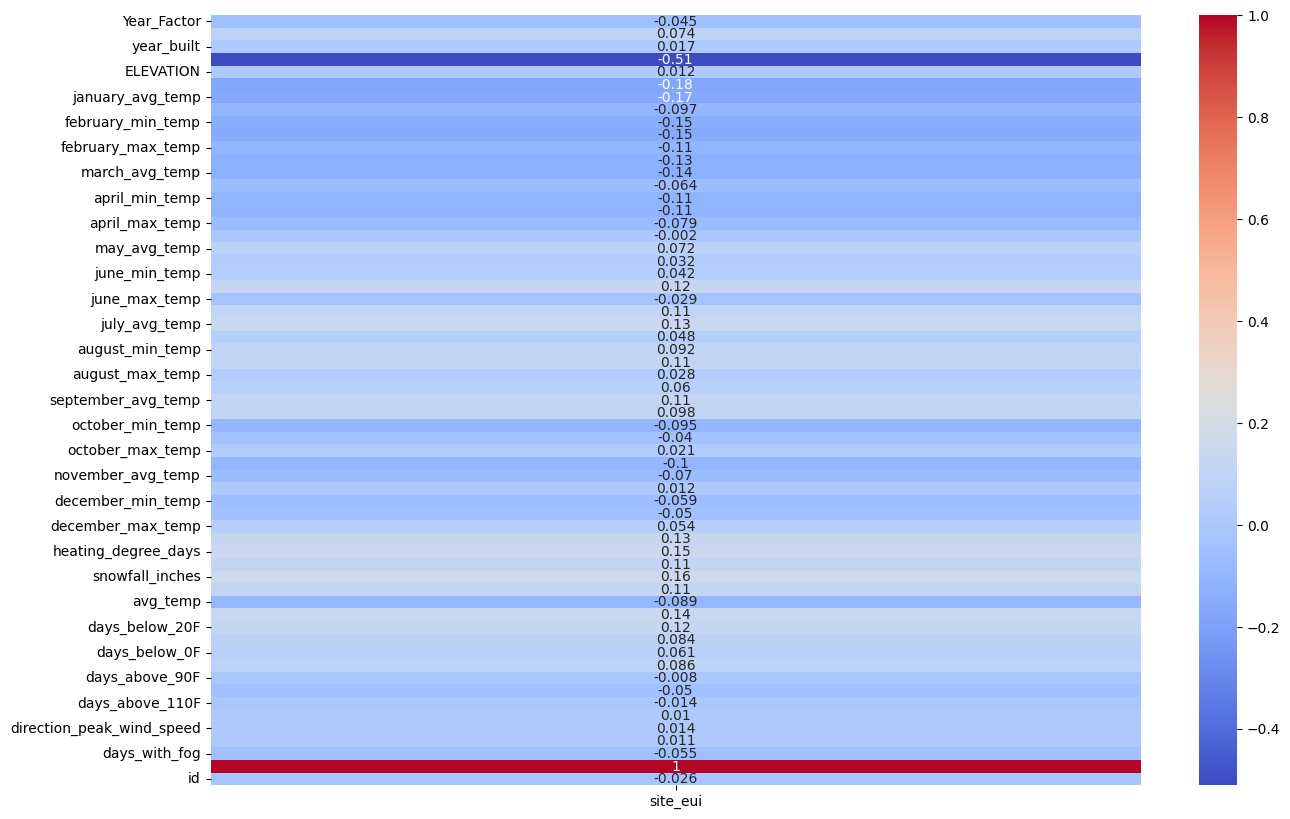

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlations only on numeric columns
numeric_train = train.select_dtypes(include='number')

plt.figure(figsize=(15, 10))
# Get correlation of 'site_eui' with other numeric columns
corr_with_site_eui = numeric_train.corr()['site_eui'].to_frame()

# Plot the heatmap
ax = sns.heatmap(corr_with_site_eui, annot=True, cmap='coolwarm')
fig = ax.get_figure()
plt.show()


In [15]:
cols_to_drop = ['direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
train.drop(cols_to_drop, axis=1, inplace=True)
train.dropna(subset=['year_built'], inplace=True)
train.fillna({"energy_star_rating": train['energy_star_rating'].mean()}, inplace=True)

In [16]:
d = []
for i in train['facility_type'].unique():
    t = []
    t.append(i)
    t.append(train[train['facility_type'] == i]['site_eui'].mean())
    t.append(train[train['facility_type'] == i]['site_eui'].std())
    t.append(train[train['facility_type'] == i]['site_eui'].max())
    t.append(train[train['facility_type'] == i]['site_eui'].min())
    d.append(t)
    df = pd.DataFrame(d, columns = ['Facility Type', 'mean site_eui', 'standard deviation site_eui', 'max site_eui', 'min site_eui'])
    df = df.round(decimals = 3)
    df = df.sort_values(by=['mean site_eui'], ascending=False).reset_index(drop=True)
    df.to_csv('facility_type_and_eui_values.csv')

Text(0.08, 0.5, 'Site EUI values')

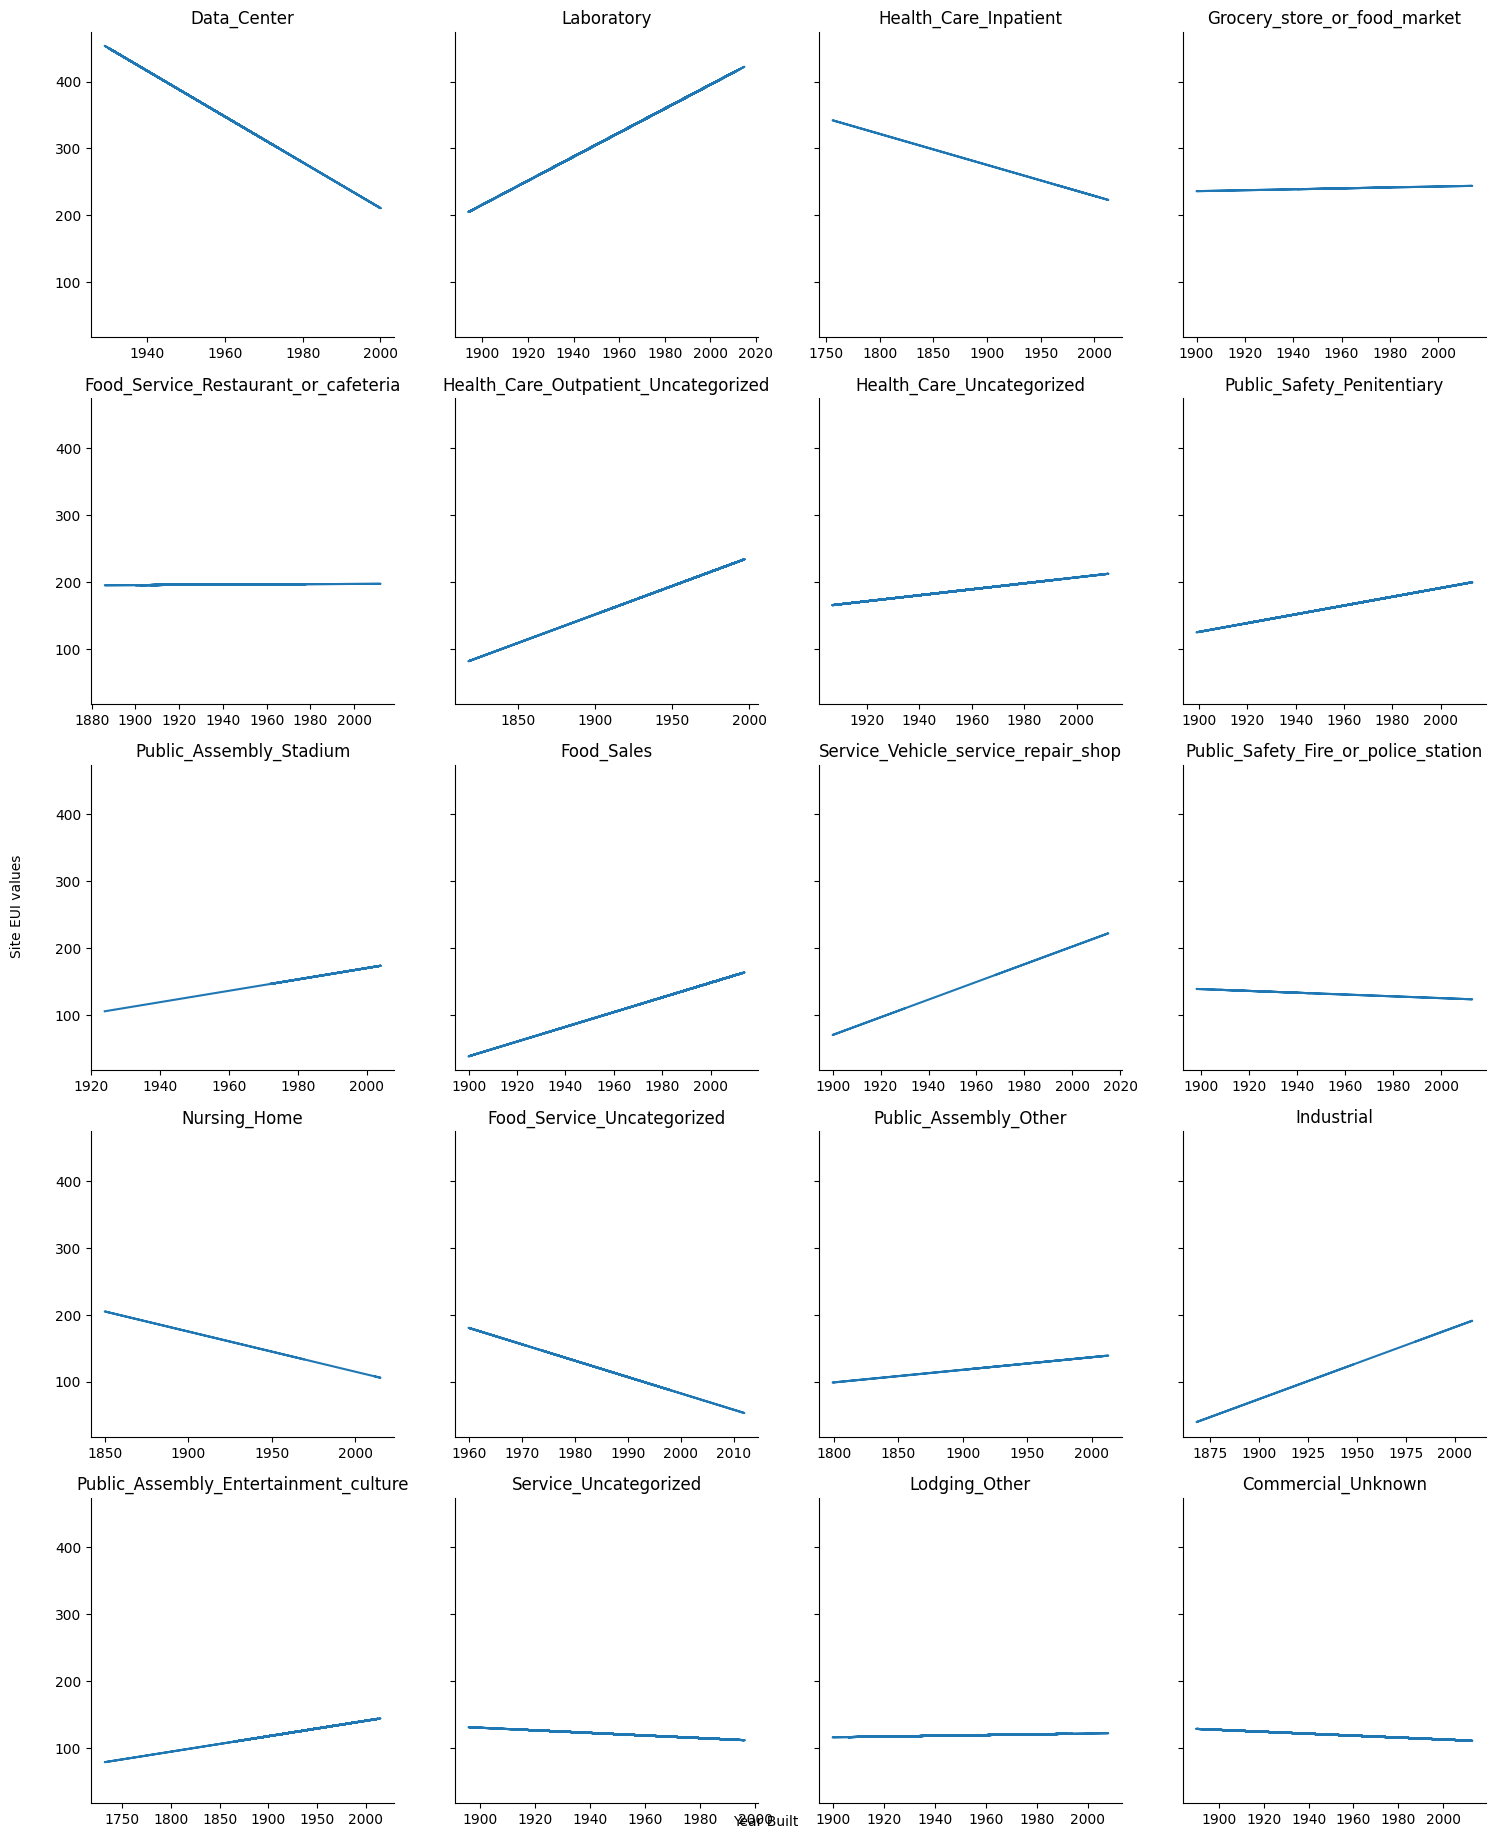

In [17]:
facility = df['Facility Type'].unique()
data = train[train['facility_type'] == 'Data_Center']
fig, ax = plt.subplots(ncols = 4, nrows = 5, figsize=(18,23), sharey=True)

for r in range(5):
    for c in range(4):
        data = train[train['facility_type'] == facility[4*r + c]]
        a, b = np.polyfit(data['year_built'], data['site_eui'], 1)
        ax[r,c].plot(data['year_built'], a*data['year_built']+b)
        ax[r,c].set_title(facility[4*r + c])
        sns.despine()
fig.text(0.5, 0.1, 'Year Built', ha='center')
fig.text(0.08, 0.5, 'Site EUI values', va='center', rotation='vertical')

One Hot Encoding

In [18]:
scaler = StandardScaler()
train_one_hot = pd.get_dummies(train)
X = train_one_hot.drop([ID,TARGET],axis = 1)
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
y = train_one_hot[TARGET]

X_train_onehot, X_test_onehot, y_train_onehot, y_test_onehot = train_test_split(X, y, test_size=TEST_SIZE, random_state=seed)

Label Encoding

In [19]:
from sklearn.preprocessing import LabelEncoder

train_copy = train.copy()
test_copy = test.copy()

#preprocess
str_list = [] 
num_list = []
for colname, colvalue in train_copy.items():
    if type(colvalue[1]) == str:
        str_list.append(colname)
    else:
        num_list.append(colname)
        
for col in str_list:
    encoder = LabelEncoder()
    encoder.fit(train_copy[col])
    train_copy[col] = encoder.transform(train_copy[col])

    for label in np.unique(test_copy[col]):
        if label not in encoder.classes_: 
            encoder.classes_ = np.append(encoder.classes_, label) 
    test_copy[col] = encoder.transform(test_copy[col])

train_one_hot = pd.get_dummies(train_copy)
X = train_one_hot.drop([ID,TARGET],axis = 1)
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
y = train_one_hot[TARGET]

X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X, y, test_size=TEST_SIZE, random_state=seed)

PCA after one-hot encoding

In [20]:
from sklearn.decomposition import PCA
train_one_hot = pd.get_dummies(train)
X = train_one_hot.drop([ID,TARGET],axis = 1)
y = train_one_hot[TARGET]
pca = PCA(n_components = 64)
X_pca = pd.DataFrame(pca.fit_transform(X))
scaler = StandardScaler()
X_pca = pd.DataFrame(scaler.fit_transform(X_pca), columns = X_pca.columns)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=TEST_SIZE, random_state=seed)

# Linear Regression

#### Simple Linear Regression

In [21]:
from sklearn.linear_model import LinearRegression

One Hot Encoding

In [22]:
model = LinearRegression()
model.fit(X_train_onehot,y_train_onehot)
pred_test=model.predict(X_test_onehot)
rmse = mean_squared_error(y_test_onehot, pred_test) ** 0.5
mae=mean_absolute_error(y_test_onehot, pred_test)
r2 = r2_score(y_test_onehot, pred_test)
print(rmse, mae, r2)

45.05354453121992 23.703295949784813 0.3781657949522773


One hot with PCA

In [23]:
model = LinearRegression()
model.fit(X_train_pca,y_train_pca)
pred_test=model.predict(X_test_pca)
rmse = mean_squared_error(y_test_onehot, pred_test) ** 0.5
mae=mean_absolute_error(y_test_pca, pred_test)
r2 = r2_score(y_test_pca, pred_test)
print(rmse, mae, r2)

46.7470390513647 24.211887055983876 0.3305395965605229


Label Encoding

In [24]:
model = LinearRegression()
model.fit(X_train_label,y_train_label)
pred_test=model.predict(X_test_label)
rmse = mean_squared_error(y_test_onehot, pred_test) ** 0.5
mae=mean_absolute_error(y_test_label, pred_test)
r2 = r2_score(y_test_label, pred_test)
print(rmse, mae, r2)

50.99961063910975 27.377046552003986 0.2031980286281304


#### Lasso Regression

One hot Encoding

In [25]:
from sklearn import linear_model
model = linear_model.LassoLars(alpha=.1)
model.fit(X_train_onehot,y_train_onehot)
pred_test=model.predict(X_test_onehot)
rmse = mean_squared_error(y_test_onehot, pred_test) ** 0.5
mae=mean_absolute_error(y_test_onehot, pred_test)
r2 = r2_score(y_test_onehot, pred_test)
print(rmse, mae, r2)

45.340669997007915 23.76958994768974 0.37021466178649487


c:\Users\Anushika Mishra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=3.849e+00, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\Anushika Mishra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=9.571e-01, with an active set of 43 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\Anushika Mishra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a reg

Label Encoder

In [26]:
from sklearn import linear_model
model = linear_model.LassoLars(alpha=.1)
model.fit(X_train_label,y_train_label)
pred_test=model.predict(X_test_label)
rmse = mean_squared_error(y_test_onehot, pred_test) ** 0.5
mae=mean_absolute_error(y_test_label, pred_test)
r2 = r2_score(y_test_label, pred_test)
print(rmse, mae, r2)

50.97381269875123 27.31141103646615 0.20400394265108224


# Random Forest

In [27]:
from sklearn.ensemble import RandomForestRegressor

One Hot Encoding

In [28]:
model = RandomForestRegressor(max_depth=12, random_state=0)
model.fit(X_train_onehot, y_train_onehot)
pred_test=model.predict(X_test_onehot)
rmse = mean_squared_error(y_test_onehot, pred_test) ** 0.5
mae=mean_absolute_error(y_test_onehot, pred_test)
r2 = r2_score(y_test_onehot, pred_test)
print(rmse, mae, r2)

41.69917868703175 22.250183653635506 0.4673135113208743


Label Encoding

In [29]:
model = RandomForestRegressor(max_depth=12, random_state=0)
model.fit(X_train_label,y_train_label)
pred_test=model.predict(X_test_label)
rmse = mean_squared_error(y_test_onehot, pred_test) ** 0.5
mae=mean_absolute_error(y_test_label, pred_test)
r2 = r2_score(y_test_label, pred_test)
print(rmse, mae, r2)

41.39066569852594 21.367239819315305 0.4751665561623074


# Neural network

In [30]:
import tensorflow as tf
import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras import regularizers
tf.random.set_seed(seed)

## Normal MLP

One Hot Encoding

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='relu')
])
model.compile(loss='mean_squared_error',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # ideal learning rate (same as default)
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.build(input_shape=X_train_onehot.shape)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (59136, 1024)          │       128,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (59136, 1024)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (59136, 512)           │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (59136, 512)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (59136, 256)           │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (59136, 256)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (59136, 128)           │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (59136, 128)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (59136, 64)            │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (59136, 64)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (59136, 32)            │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (59136, 32)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (59136, 1)             │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 827,393 (3.16 MB)

 Trainable params: 827,393 (3.16 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history = model.fit(
    X_train_onehot,
    y_train_onehot,
    epochs=30
)

Epoch 1/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 3151.2402 - root_mean_squared_error: 55.8592
Epoch 2/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - loss: 2558.9309 - root_mean_squared_error: 50.5707
Epoch 3/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 2502.5857 - root_mean_squared_error: 50.0129
Epoch 4/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 2428.5925 - root_mean_squared_error: 49.2670
Epoch 5/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 2407.3389 - root_mean_squared_error: 49.0548
Epoch 6/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 2373.0923 - root_mean_squared_error: 48.6930
Epoch 7/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 2325.1104 - root_mean_squared_error: 48.2005
Epoch 8/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 2272.1743 - root_mean_squared_error: 47.6464
Epoch 9/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 2243.0430 - root_mean_squared_error: 47.3465
Epoch 10/30
1848/18

In [33]:
pred_test = model.predict(X_test_onehot)
rmse = mean_squared_error(y_test_onehot, pred_test) ** 0.5
mae=mean_absolute_error(y_test_onehot, pred_test)
r2 = r2_score(y_test_onehot, pred_test)
print(rmse, mae, r2)

462/462 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
43.13306332303043 23.064884451532095 0.4300493084675562


Label Encoding

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='relu')
])

model.compile(loss='mean_squared_error',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # ideal learning rate (same as default)
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(
    X_train_label,
    y_train_label,
    epochs=30
)

Epoch 1/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - loss: 3396.5967 - root_mean_squared_error: 58.1425
Epoch 2/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 2921.5901 - root_mean_squared_error: 54.0272
Epoch 3/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 2854.0762 - root_mean_squared_error: 53.3982
Epoch 4/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 2808.1963 - root_mean_squared_error: 52.9633
Epoch 5/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 2704.4624 - root_mean_squared_error: 51.9765
Epoch 6/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 2641.7993 - root_mean_squared_error: 51.3710
Epoch 7/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 2631.8818 - root_mean_squared_error: 51.2737
Epoch 8/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 2591.3086 - root_mean_squared_error: 50.8737
Epoch 9/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 2580.4155 - root_mean_squared_error: 50.7670
Epoch 10/30
1848/18

In [35]:
pred_test=model.predict(X_test_label)
rmse = mean_squared_error(y_test_onehot, pred_test) ** 0.5
mae=mean_absolute_error(y_test_label, pred_test)
r2 = r2_score(y_test_label, pred_test)
print(rmse, mae, r2)

462/462 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
46.20743857486434 24.324310147852245 0.34590554310899446


## With L2 Regularization

One Hot Encoding

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='relu', kernel_regularizer = regularizers.L2(1e-1))
])

model.compile(loss='mean_squared_error',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # ideal learning rate (same as default)
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(
    X_train_onehot,
    y_train_onehot,
    epochs=30
)

Epoch 1/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - loss: 3238.3594 - root_mean_squared_error: 55.5687
Epoch 2/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 2607.8235 - root_mean_squared_error: 50.2635
Epoch 3/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 2544.1426 - root_mean_squared_error: 49.7568
Epoch 4/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 2495.6860 - root_mean_squared_error: 49.3387
Epoch 5/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 2487.1074 - root_mean_squared_error: 49.2823
Epoch 6/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 2440.4148 - root_mean_squared_error: 48.8173
Epoch 7/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 2430.0076 - root_mean_squared_error: 48.7028
Epoch 8/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 2368.0901 - root_mean_squared_error: 48.0691
Epoch 9/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 2301.9766 - root_mean_squared_error: 47.3422
Epoch 10/30
1848/18

In [37]:
pred_test = model.predict(X_test_onehot)
rmse = mean_squared_error(y_test_onehot, pred_test) ** 0.5
mae=mean_absolute_error(y_test_onehot, pred_test)
r2 = r2_score(y_test_onehot, pred_test)
print(rmse, mae, r2)

462/462 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
42.6844973398899 22.378197222914338 0.4418421694939243


Label Encoding

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = regularizers.L2(1e-1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='relu', kernel_regularizer = regularizers.L2(1e-1))
])

model.compile(loss='mean_squared_error',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # ideal learning rate (same as default)
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(
    X_train_label,
    y_train_label,
    epochs=30
)

Epoch 1/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 53s 24ms/step - loss: 3519.2219 - root_mean_squared_error: 58.2874
Epoch 2/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 28912s 16s/step - loss: 2935.6357 - root_mean_squared_error: 53.5731
Epoch 3/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - loss: 2854.5798 - root_mean_squared_error: 52.9208
Epoch 4/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 1758s 952ms/step - loss: 2795.0442 - root_mean_squared_error: 52.4126
Epoch 5/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - loss: 2749.0916 - root_mean_squared_error: 51.9890
Epoch 6/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 2682.0615 - root_mean_squared_error: 51.3150
Epoch 7/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 2649.7949 - root_mean_squared_error: 50.9692
Epoch 8/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 2612.9099 - root_mean_squared_error: 50.5717
Epoch 9/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 2599.8765 - root_mean_squared_error: 50.4006
Epoch 10/30
1848/1

In [39]:
pred_test=model.predict(X_test_label)
rmse = mean_squared_error(y_test_onehot, pred_test) ** 0.5
mae=mean_absolute_error(y_test_label, pred_test)
r2 = r2_score(y_test_label, pred_test)
print(rmse, mae, r2)

462/462 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
46.116161570783845 24.0321220340011 0.3484871540175527


## L1 regularization

One Hot Encoding

In [40]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="relu", kernel_regularizer = regularizers.L1(0.4))
])

model.compile(loss='mean_squared_error',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # ideal learning rate (same as default)
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(
    X_train_onehot,
    y_train_onehot,
    epochs=30
)

Epoch 1/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 6160.6611 - root_mean_squared_error: 54.3993
Epoch 2/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 2941.6819 - root_mean_squared_error: 49.4286
Epoch 3/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 2710.7480 - root_mean_squared_error: 48.4894
Epoch 4/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 2683.0059 - root_mean_squared_error: 48.8370
Epoch 5/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 2611.1294 - root_mean_squared_error: 48.4099
Epoch 6/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 2573.9487 - root_mean_squared_error: 48.1561
Epoch 7/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 2535.8035 - root_mean_squared_error: 47.8898
Epoch 8/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - loss: 2516.3347 - root_mean_squared_error: 47.7083
Epoch 9/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - loss: 2506.5237 - root_mean_squared_error: 47.6319
Epoch 10/30
1848/1848

In [41]:
pred_test = model.predict(X_test_onehot)
rmse = mean_squared_error(y_test_onehot, pred_test) ** 0.5
mae=mean_absolute_error(y_test_onehot, pred_test)
r2 = r2_score(y_test_onehot, pred_test)
print(rmse, mae, r2)

462/462 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
43.26545540665541 22.522668406412652 0.426545139873164


Label Encoding

In [42]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer = regularizers.L1(0.4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="relu", kernel_regularizer = regularizers.L1(0.4))
])

model.compile(loss='mean_squared_error',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # ideal learning rate (same as default)
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(
    X_train_label,
    y_train_label,
    epochs=30
)

Epoch 1/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 5456.0259 - root_mean_squared_error: 60.9010
Epoch 2/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 3218.0271 - root_mean_squared_error: 53.8196
Epoch 3/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 3111.8213 - root_mean_squared_error: 53.3215
Epoch 4/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 3034.5137 - root_mean_squared_error: 52.7960
Epoch 5/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 2996.2834 - root_mean_squared_error: 52.4995
Epoch 6/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 2962.4512 - root_mean_squared_error: 52.2537
Epoch 7/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 2943.4500 - root_mean_squared_error: 52.1226
Epoch 8/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 2885.3687 - root_mean_squared_error: 51.5918
Epoch 9/30
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 2885.0881 - root_mean_squared_error: 51.6336
Epoch 10/30
1848/1848 ━

In [43]:
pred_test = model.predict(X_test_label)
rmse = mean_squared_error(y_test_onehot, pred_test) ** 0.5
mae=mean_absolute_error(y_test_label, pred_test)
r2 = r2_score(y_test_label, pred_test)
print(rmse, mae, r2)

462/462 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
46.594518217845724 23.965409431127473 0.3349009460666984


# CatBoost Model

In [5]:
import sys
!"{sys.executable}" -m pip install catboost

  Using cached plotly-6.0.1-py3-none-any.whl.metadata (6.7 kB)
  Using cached narwhals-1.36.0-py3-none-any.whl.metadata (9.2 kB)
   --------------------------------------- 102.5/102.5 MB 13.4 MB/s eta 0:00:00
Using cached plotly-6.0.1-py3-none-any.whl (14.8 MB)
Using cached narwhals-1.36.0-py3-none-any.whl (331 kB)



[notice] A new release of pip is available: 25.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [67]:
import random,os
from catboost import CatBoostRegressor

ID = "id"
TARGET = "site_eui"

TEST_SIZE = 0.2

SEED = 2022
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything()

MODEL_MAX_DEPTH = 12
MODEL_TASK_TYPE = 'CPU'
MODEL_RL = 0.025
MODEL_EVAL_METRIC ='RMSE'
MODEL_LOSS_FUNCTION = 'RMSE'
MODEL_ESR = 10
MODEL_VERBOSE = 500
MODEL_ITERATIONS = 5000

One-hot encoding

In [68]:
model = CatBoostRegressor(
    verbose=MODEL_VERBOSE,
    early_stopping_rounds=MODEL_ESR,
    random_seed=SEED,
    max_depth=MODEL_MAX_DEPTH,
    task_type=MODEL_TASK_TYPE,
    learning_rate=MODEL_RL,
    iterations=MODEL_ITERATIONS,
    loss_function=MODEL_LOSS_FUNCTION,
    eval_metric= MODEL_EVAL_METRIC,
    train_dir = r"C:\Users\Anushika Mishra\OneDrive\datascience_project"
)
history = model.fit(X_train_onehot, y_train_onehot)

0:	learn: 57.5637067	total: 256ms	remaining: 21m 17s
500:	learn: 37.0630365	total: 1m 7s	remaining: 10m 1s
1000:	learn: 33.0908405	total: 2m 10s	remaining: 8m 40s
1500:	learn: 30.7377839	total: 3m 11s	remaining: 7m 27s
2000:	learn: 28.8757771	total: 4m 13s	remaining: 6m 20s
2500:	learn: 27.4379062	total: 5m 17s	remaining: 5m 17s
3000:	learn: 26.1594160	total: 6m 18s	remaining: 4m 12s
3500:	learn: 25.0758776	total: 7m 21s	remaining: 3m 8s
4000:	learn: 24.0740461	total: 8m 22s	remaining: 2m 5s
4500:	learn: 23.2517263	total: 9m 24s	remaining: 1m 2s
4999:	learn: 22.5354431	total: 10m 26s	remaining: 0us


In [69]:
pred_test = model.predict(X_test_onehot)
rmse = mean_squared_error(y_test_onehot, pred_test) ** 0.5
mae=mean_absolute_error(y_test_onehot, pred_test)
r2 = r2_score(y_test_onehot, pred_test)
print(rmse, mae, r2)

37.33714607051979 19.12486933218557 0.572930145875849


Label Encoding

In [70]:
model = CatBoostRegressor(
    verbose=MODEL_VERBOSE,
    early_stopping_rounds=MODEL_ESR,
    random_seed=SEED,
    max_depth=MODEL_MAX_DEPTH,
    task_type=MODEL_TASK_TYPE,
    learning_rate=MODEL_RL,
    iterations=MODEL_ITERATIONS,
    loss_function=MODEL_LOSS_FUNCTION,
    eval_metric= MODEL_EVAL_METRIC
)
model.fit(X_train_label, y_train_label)

0:	learn: 57.5243991	total: 128ms	remaining: 10m 39s
500:	learn: 36.7511653	total: 1m 8s	remaining: 10m 17s
1000:	learn: 32.8736055	total: 2m 17s	remaining: 9m 8s
1500:	learn: 30.2460006	total: 3m 24s	remaining: 7m 56s
2000:	learn: 28.3708896	total: 4m 31s	remaining: 6m 46s
2500:	learn: 26.7548675	total: 5m 38s	remaining: 5m 38s
3000:	learn: 25.3904059	total: 6m 48s	remaining: 4m 32s
3500:	learn: 24.2291473	total: 7m 56s	remaining: 3m 24s
4000:	learn: 23.2079790	total: 9m 2s	remaining: 2m 15s
4500:	learn: 22.3383211	total: 10m 8s	remaining: 1m 7s
4999:	learn: 21.5327699	total: 11m 15s	remaining: 0us


In [71]:
pred_test = model.predict(X_test_label)
rmse = mean_squared_error(y_test_onehot, pred_test) ** 0.5
mae=mean_absolute_error(y_test_label, pred_test)
r2 = r2_score(y_test_label, pred_test)
print(rmse, mae, r2)

38.128354428432786 19.576438619528112 0.5546383645024033
